In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from scipy.stats import mode

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [3]:
predictions = []

In [4]:
# Check if the file is open
if os.access("spam.csv", os.R_OK):
    data = pd.read_csv("spam.csv", encoding='ISO-8859-1')
else:
    print("File is open or you don't have permission to access it.")
data = pd.read_csv("spam.csv", encoding='ISO-8859-1')


In [5]:
print(data.tail())


        v1                                                 v2 Unnamed: 2  \
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  


In [6]:
print(data.isnull().sum())

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [7]:
X = data['v2']  # Messages
y = data['v1']  # Labels ('ham'/'spam')

In [8]:
# Changing the labels from 'ham' and 'spam' to 0 and 1
y=LabelEncoder().fit_transform(y)

In [9]:
# Splitting the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Converting the messages into numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()
X_train_tfidf, X_test_tfidf 

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.24340433, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

### Using Deep Learning

In [11]:
# Converting everything to tensors for PyTorch
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [12]:
# Moving the data to the GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

In [13]:
# Defining a simple feedforward neural network for classification
class SpamClassifier(nn.Module):
    def __init__(self, input_size):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [14]:
# Creating the model and putting it on the GPU if it's available
model = SpamClassifier(input_size=X_train_tfidf.shape[1]).to(device)

In [15]:
# Setting up binary cross-entropy as the loss function and Adam as the optimizer
lossfn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
# Training loop: runs for 10 epochs
num_epochs = 19
for epoch in range(num_epochs):
    model.train()  # Making sure the model is in training mode
    for inputs, labels in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True):
        # Forward pass: making predictions
        outputs = model(inputs)
        loss = lossfn(outputs, labels)
        
        # Backward pass: calculating gradients and updating weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/19, Loss: 0.652907133102417
Epoch 2/19, Loss: 0.5888122916221619
Epoch 3/19, Loss: 0.4308682084083557
Epoch 4/19, Loss: 0.29116907715797424
Epoch 5/19, Loss: 0.2847677171230316
Epoch 6/19, Loss: 0.1695992797613144
Epoch 7/19, Loss: 0.16336573660373688
Epoch 8/19, Loss: 0.23388439416885376
Epoch 9/19, Loss: 0.18602195382118225
Epoch 10/19, Loss: 0.16796500980854034
Epoch 11/19, Loss: 0.061362020671367645
Epoch 12/19, Loss: 0.05922660604119301
Epoch 13/19, Loss: 0.03528711572289467
Epoch 14/19, Loss: 0.08640078455209732
Epoch 15/19, Loss: 0.03980502113699913
Epoch 16/19, Loss: 0.05215984210371971
Epoch 17/19, Loss: 0.03388689085841179
Epoch 18/19, Loss: 0.05999045446515083
Epoch 19/19, Loss: 0.0427737832069397


In [17]:
# Evaluation: testing the model on the test set
model.eval()  # Switch to evaluation mode
with torch.no_grad():  # No need to calculate gradients during evaluation
    test_outputs = model(X_test_tensor)
    test_outputs = (test_outputs > 0.5).float()  # Convert probabilities to binary predictions
    accuracydl = (test_outputs == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracydl * 100:.2f}%')
    predictions.append(test_outputs.squeeze().cpu().numpy())
    

Test Accuracy: 97.76%


In [18]:
def makepreds(text):
    
    # The text must be wrapped in a list to transform it properly
    vector = vectorizer.transform([text])
    
    # Move the input to tensor and GPU if available
    input_tensor = torch.tensor(vector.toarray(), dtype=torch.float32).to(device)
    
    # Make sure the model is in evaluation mode
    model.eval()
    
    # Predict the output
    with torch.no_grad():
        prediction = model(input_tensor)
    
    # Convert the prediction to binary (0 or 1) based on a threshold
    return "spam" if prediction.item() > 0.5 else "ham"

In [19]:
makepreds("WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.")

'spam'

In [20]:
"""# Specify the path where the model will be saved
model_save_path = "spam_classifier_model.pth"

# Save the model's state dictionary (this contains the trained parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")"""

'# Specify the path where the model will be saved\nmodel_save_path = "spam_classifier_model.pth"\n\n# Save the model\'s state dictionary (this contains the trained parameters)\ntorch.save(model.state_dict(), model_save_path)\n\nprint(f"Model saved to {model_save_path}")'

In [21]:
# Initialize the same model architecture
model = SpamClassifier(input_size=X_train_tfidf.shape[1])

# Load the state dictionary (trained parameters) into the model
model.load_state_dict(torch.load("spam_classifier_model.pth"))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Ezaz\AppData\Local\Temp\ipykernel_4852\2702470331.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("spam_classifier_model.pth"))

### Using Logistic Regression

In [22]:
#Training the model
model = LogisticRegression()

In [23]:
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [24]:
#Accuracy for the training data
prediction_on_training_data = model.predict(X_train_tfidf)
accuracy_on_training_data = accuracy_score(y_train, prediction_on_training_data)
prediction_on_training_data 

#Printing the accuracy for the training data
print('Accuracy on training data: ', accuracy_on_training_data)

Accuracy on training data:  0.9780121157729414


In [25]:
#Accuracy for the test data
prediction_on_test_data = model.predict(X_test_tfidf)
accuracy_on_test_datalr = accuracy_score(y_test, prediction_on_test_data)

#Printing the accuracy for the test data
print('Accuracy on test data: ', accuracy_on_test_datalr)
predictions.append(prediction_on_test_data)

Accuracy on test data:  0.968609865470852


### Using SVM

In [26]:
# Step 4: Train an SVM classifier
svm_model = SVC(kernel='linear')  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [27]:
# Step 5: Make predictions and evaluate
y_pred = svm_model.predict(X_test_tfidf)


In [28]:
# Calculate accuracy
accuracysvm = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracysvm:.2f}')
predictions.append(y_pred)

Accuracy: 0.98


### Random Forest

In [29]:
# Step 4: Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)





RandomForestClassifier(random_state=42)

In [30]:
# Step 5: Make predictions and evaluate
y_pred = rf_model.predict(X_test_tfidf)

In [31]:
# Calculate accuracy
accuracyrf = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracyrf:.2f}')
predictions.append(y_pred)

Accuracy: 0.98


### Descision Tree

In [32]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)





DecisionTreeClassifier(random_state=42)

In [33]:

# Step 5: Make predictions and evaluate
y_pred = dt_model.predict(X_test_tfidf)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [34]:
# Calculate accuracy
accuracydt = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracydt:.2f}')
predictions.append(y_pred)


Accuracy: 0.97


### Using Ensamble


In [35]:
# Combine predictions using majority voting
predictions= np.array(predictions)
from collections import Counter

# Manually compute mode for each column
result = []
for col in predictions.T:  # Transpose to iterate over columns
    count = Counter(col)  # Count occurrences
    most_common_value = count.most_common(1)[0][0]  # Get the most common value
    result.append(most_common_value)

ensemble_pred = np.array(result)  # Convert the result back to a numpy array


accuracye = accuracy_score(y_test, ensemble_pred)
print(f'Ensemble Accuracy: {accuracye:.2f}')


Ensemble Accuracy: 0.98


### Comparing Results


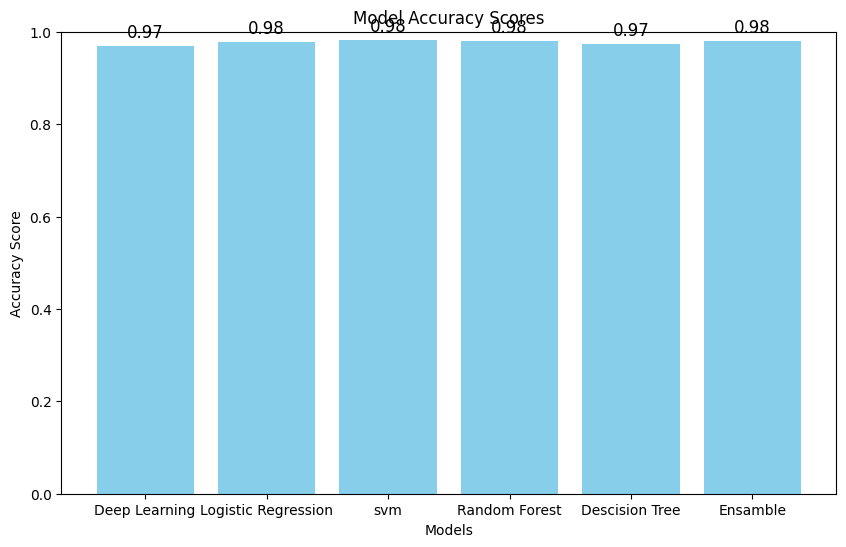

In [36]:
import matplotlib.pyplot as plt

# Example data
models = ['Deep Learning', 'Logistic Regression','svm','Random Forest','Descision Tree','Ensamble']  # Replace with your model names
accuracy_scores = [accuracy_on_test_datalr, accuracydl,accuracysvm,accuracyrf,accuracydt,accuracye]  # Replace with your accuracy scores

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(models, accuracy_scores, color='skyblue')  # Create bars

# Add title and labels
plt.title('Model Accuracy Scores')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1

# Add accuracy scores on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()
